In [18]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [19]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[7.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])

effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTx,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTx(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTx(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTx(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTx(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [20]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 33.762791 seconds (219.24 M allocations: 42.291 GiB, 11.96% gc time)


3.0

In [21]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [22]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=5.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [23]:
NPx=5.0
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,NPx)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [24]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,NPx)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [25]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,NPx)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [35]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.10
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

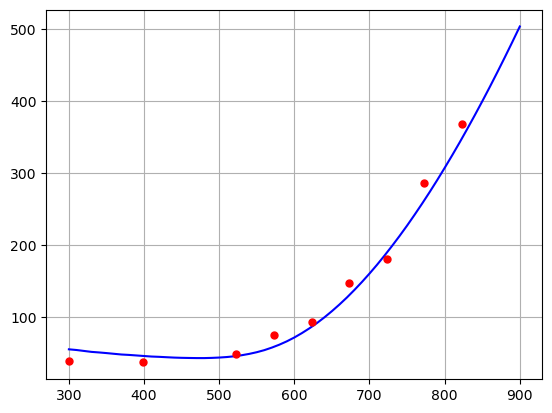

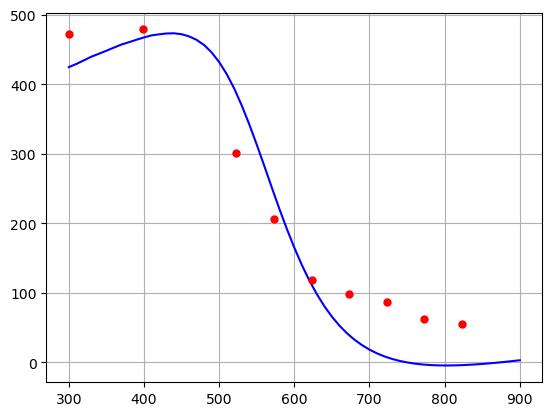

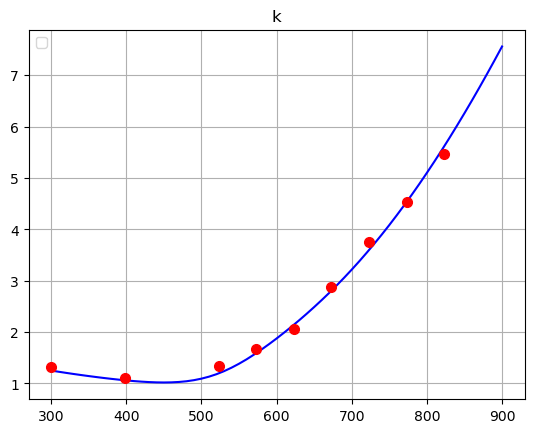

No handles with labels found to put in legend.


In [36]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2ECE,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2SCS,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2KCK,linestyle="None",marker="o",markersize=7,color="r")

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [37]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [38]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

1.2513298366724275
1.228317159231118
1.2059637074345986
1.184381164678001
1.163810802930383
1.144012889406221
1.1250105232734657
1.1069115860333765
1.0900572514520717
1.0742172616923773
1.0596549769134493
1.046648378045117
1.0358371055443125
1.0271896533553408
1.0213908359886992
1.0192857757410918
1.0216565802560191
1.0291584933347728
1.0428638023228718
1.0642301118741153
1.0938053636023064
1.1323167023176388
1.1803932059822964
1.2390963366129082
1.3071300495789053
1.384100958122938
1.469240946396344
1.5627890289212805
1.6618903384219983
1.766224930271353
1.8756708509367352
1.9899291466637352
2.1078234415882355
2.2297191208427742
2.3565285766719386
2.487655332976762
2.6231147727445845
2.763337501906965
2.9094333570777717
3.0604258462589646
3.2166543064857755
3.378385788078438
3.5466440599795557
3.7201652706931503
3.8993836094604184
4.084425505249213
4.276206688102824
4.4733174106136335
4.676228507051707
4.885338033778943
5.100391809854513
5.32101168637295
5.547320450655077
5.7797536103

In [39]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

5477.766315566058
5383.197176563184
5253.1504970948245
5123.377872521051
5044.809158001611
4954.731108330765
4854.683930249348
4756.558865236683
4699.378043490688
4624.508093363561
4547.620342208905
4474.16040103684
4434.027819605793
4379.794459325143
4329.35421026635
4295.590330085366
4275.932471575532
4260.933160734935
4259.585018239425
4287.266372488218
4334.316157510511
4405.012588348429
4506.908010747707
4656.961150546668
4844.0912128643395
5077.030513079465
5361.868319229406
5715.090134529213
6121.043906200751
6587.913231576404
7122.415531461399
7726.616548310025
8390.98188926903
9118.857991098717
9918.214214766927
10780.133477420193
11701.152277598021
12682.31148880751
13733.444914967256
14839.46532231717
16001.16059306518
17219.02995128854
18504.50072330192
19838.57887570464
21225.2399045467
22664.78169280554
24169.449392279508
25717.99093796732
27316.5090049738
28970.577306761523
30676.220533801777
32427.568985639366
34226.50613829501
36080.01076938254
37979.002182570424
39922

In [40]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-424.83497157618575
-429.40630137166244
-434.6415818991177
-439.8950614350982
-444.08307115572694
-448.4557153584894
-452.9892291116911
-457.40523852649204
-460.72947228385357
-464.27417548879936
-467.6091437916138
-470.50280702479887
-472.03007894975775
-473.2572672013846
-473.5142349287367
-472.187695071837
-469.04422934730104
-464.0349424416345
-456.57212739214725
-445.8839797635241
-432.03105450718994
-414.79432866523905
-394.0480783954904
-369.62886063903227
-342.50201215437926
-313.25542771523266
-282.7211348751723
-251.54981282395826
-221.14020025307337
-192.11272204783504
-164.9601476292036
-140.0704794622897
-117.78153589102918
-98.05660425795973
-80.73018789269439
-65.73735476203953
-52.889132127923475
-41.94720830552351
-32.645331875809
-24.851606054983176
-18.360713597573476
-12.993929539249885
-8.573584754051964
-5.0099590052554674
-2.172778700641551
0.041249799682538106
1.730370575927087
2.9488677284051756
3.769436739866563
4.250484346907634
4.437327971991629
4.3701969021

In [41]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

0.028581773489809694
0.029726373390747633
0.030662551115352155
0.03150095729313729
0.03247492914511228
0.03333137252429173
0.03406526628769656
0.03473368183473792
0.035577812376889256
0.03626351623719879
0.03687842476995836
0.037459966960200465
0.03824074849234077
0.03887663517825073
0.03950093756914246
0.04022912747231749
0.04105298761882794
0.04189322491393538
0.04283749627388246
0.044049164310585566
0.04544566831320798
0.0470801079191389
0.04904517781423458
0.05154868584668808
0.054484870453325396
0.05797230487805946
0.062105607105303495
0.06711858428061845
0.07284357246556922
0.07941302000633821
0.0869500399734866
0.09552154499721965
0.10503001390822941
0.11555672544478646
0.12725844415239063
0.14004164413000664
0.15388762865401528
0.1688465394044747
0.18511566877896168
0.2024855819917869
0.22100001842125017
0.24069905327434604
0.2618182030127614
0.284056332045886
0.30751218537690983
0.33222084961760157
0.35844475952389865
0.3858152902387548
0.4144746263534269
0.44456149645690335
0

In [42]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

2.0170862692278696e-5
4.1781856450682406e-5
8.213432628136633e-5
0.00015494675085921537
0.0002846693406242486
0.0005040767039297276
0.0008628665487114567
0.0014350062653966
0.0023447431875839616
0.003720955143352688
0.005764779268885793
0.00874233302626041
0.013086162261484742
0.019134177919626377
0.02746279651512412
0.038826095870668625
0.05403825113717242
0.07385700023725439
0.0992894701626722
0.13165165411871105
0.17159503131894407
0.21981383075366798
0.27686381604123295
0.34361721485236096
0.4189015134509414
0.5022217250355644
0.5927313059831897
0.6904508883819624
0.7927079498741165
0.899064059860702
1.0092874231082138
1.123024782657984
1.2392092608848713
1.3581363382799077
1.480572442362832
1.6060248762292244
1.7345374530545425
1.8664998763619394
2.0028334600506486
2.142779470614685
2.28664140609644
2.4346537403996673
2.5876118440161937
2.7445597581909076
2.905839342486407
3.071548030921582
3.2423449040923487
3.41719433487107
3.5964301941238164
3.780316771429295
3.9686511986373825

In [43]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

1.2227278923199254
1.1985490039839197
1.175219021992965
1.1527252606340044
1.1310512044446466
1.1101774401779996
1.0900823904370578
1.070742897933242
1.0521346958875983
1.034232790311826
1.0170117728746053
1.0004460780586562
0.9845101947904868
0.9691788402574637
0.9544271019044326
0.9402305523981057
0.9265653415000188
0.9134082681835831
0.9007368358863171
0.8885292934448187
0.8767646639701543
0.865422763644832
0.8544842121268288
0.8439304359138592
0.8337436656746384
0.8239069282093142
0.8144040333078508
0.8052195562586995
0.7963388160823126
0.7877478504043127
0.7794333878550349
0.7713828190085316
0.7635841667951347
0.7560260571180801
0.748697690156716
0.741588812617531
0.7346896910360268
0.7279910861405507
0.7214842282481615
0.715160793652493
0.7090128819680855
0.7030329944044243
0.6972140129506005
0.6915491804563565
0.6860320815971014
0.6806566247100287
0.6754170244865767
0.6703077855038087
0.6653236865744643
0.6604597658927449
0.6557113069505716
0.6510738251971808
0.6465430554135287
